In [1]:
# 2.0 - Preprocesamiento de Texto Médico (NLP)
# ==============================================================================
# Este notebook se encarga de:
# 1. Cargar el dataset maestro unificado.
# 2. Limpiar el texto: quitar ruido, lematizar y  manejo de negaciones.
# 3. Codificar las etiquetas (Especialidades -> Números).
# 4. Guardar los datos listos para entrenar y el codificador (LabelEncoder).

import pandas as pd
import matplotlib.pyplot as plt
import spacy
import pickle
import os
import re
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
from wordcloud import WordCloud

print("✅ librerías cargadas.")

✅ librerías cargadas.


In [2]:
# Configuración de Rutas
INPUT_FILE = '../data/processed/datos_triaje_unificados.csv'
OUTPUT_DATA_FILE = '../data/processed/datos_nlp_procesados.csv'
MODELS_PATH = '../models/'

# Crear carpeta de modelos si no existe
os.makedirs(MODELS_PATH, exist_ok=True)

# Configurar pandas para ver texto completo
pd.set_option('display.max_colwidth', 150)

print("✅ Entorno configurado.")

✅ Entorno configurado.


In [3]:
# 1. Cargar Dataset
try:
    df = pd.read_csv(INPUT_FILE)
    print(f"📄 Datos cargados: {len(df)} registros.")
except FileNotFoundError:
    print(f"❌ Error: No se encuentra {INPUT_FILE}. Ejecuta el notebook 1.0 primero.")

# 2. Cargar Spacy (Modelo en español)
print("⏳ Cargando modelo de lenguaje Spacy (es_core_news_sm)...")
try:
    nlp = spacy.load("es_core_news_sm")
    print("✅ Spacy cargado correctamente.")
except OSError:
    print("⚠️ El modelo de Spacy no está instalado. Ejecuta: !python -m spacy download es_core_news_sm")

📄 Datos cargados: 22086 registros.
⏳ Cargando modelo de lenguaje Spacy (es_core_news_sm)...
✅ Spacy cargado correctamente.


In [4]:
# --- PERSONALIZACIÓN DE STOPWORDS ---
# Palabras vacías que normalmente se borran, pero en medicina son VITALES.
negaciones_medicas = {'no', 'sin', 'ni', 'nunca', 'jamás', 'tampoco', 'nada', 'poco'}

# Modificar la lista de stopwords de Spacy para excluirlas
for palabra in negaciones_medicas:
    nlp.vocab[palabra].is_stop = False

def limpiar_texto_medico(texto):
    """
    1. Convierte a minúsculas.
    2. Elimina símbolos raros.
    3. Tokeniza y Lematiza (convierte 'dolores' -> 'dolor').
    4. Mantiene las negaciones.
    """
    if not isinstance(texto, str): return ""
    
    # Pre-limpieza básica (quitar números sueltos y símbolos extraños)
    # Dejamos letras, espacios y tildes
    texto = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚñÑ\s]', '', texto) 
    
    doc = nlp(texto.lower())
    tokens_limpios = []
    
    for token in doc:
        # Filtros:
        # 1. No es puntuación
        # 2. No es stopword (excepto nuestras negaciones protegidas)
        # 3. Tiene más de 1 letra
        if not token.is_punct and not token.is_stop and len(token.text) > 1:
            tokens_limpios.append(token.lemma_)
            
    return " ".join(tokens_limpios)

# Prueba rápida
ejemplo = df['sintomas'][20]
print(f"Original: {ejemplo}")
print(f"Procesado: {limpiar_texto_medico(ejemplo)}")

Original: El paciente no presenta dolores de cabeza ni fiebre, pero sí tiene tos persistente.
Procesado: paciente no presentar dolor cabeza ni fiebre tos persistente


In [5]:
print("🧹 Procesando textos (esto puede tardar unos minutos)...")
tqdm.pandas()

# Limpieza
df['sintomas_procesados'] = df['sintomas'].progress_apply(limpiar_texto_medico)

# Eliminar filas que quedaron vacías después de la limpieza
df = df[df['sintomas_procesados'].str.len() > 3]
print(f"✅ Limpieza finalizada. Registros válidos: {len(df)}")

display(df[['sintomas', 'sintomas_procesados', 'especialidad']].head())

🧹 Procesando textos (esto puede tardar unos minutos)...


  0%|          | 0/22086 [00:00<?, ?it/s]

✅ Limpieza finalizada. Registros válidos: 22086


,sintomas,sintomas_procesados,especialidad
0,Se queja de hiperemia conjuntival desde esta mañana.,quejar hiperemia conjuntival mañana,OFTALMOLOGÍA/ORL
1,"Temblor distal fino, sumado a polidipsia y poliuria.",temblor distal fino sumado polidipsia poliurio,ENDOCRINOLOGÍA/NUTRICIÓN
2,Paciente de 70 años que acude a nuestro Servicio por disminución de agudeza visual del ojo izquierdo.\nEntre los antecedentes personales destacaba...,paciente año acudir servicio disminución agudeza visual ojo izquierdo antecedente personal destacar diabetes mellitus tipo dislipidemiir hipertens...,ONCOLOGÍA (TUMORES)
3,"DIAGNÓSTICO PREOPERATORIO:, Varices.,DIAGNÓSTICO POSTOPERATORIO:, Varices.,PROCEDIMIENTO REALIZADO:,1. Ligadura y desprendimiento de la vena safe...",diagnóstico preoperatorio varicesdiagnóstico postoperatorio varicesprocedimiento ligadura desprendimiento vena safén izquierda nivel rodilla extra...,CARDIOLOGÍA/CIRCULATORIO
4,Presento dolor pleurítico intermitente.,presento dolor pleurítico intermitente,RESPIRATORIO/NEUMOLOGÍA


In [6]:
print("🏷️ Codificando etiquetas de especialidad...")

label_encoder = LabelEncoder()
df['label_num'] = label_encoder.fit_transform(df['especialidad'])

# Ver el mapeo
mapeo = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapeo de Clases:", mapeo)

# Guardar el LabelEncoder (¡MUY IMPORTANTE PARA LA APP FINAL!)
with open(os.path.join(MODELS_PATH, 'label_encoder.pkl'), 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("💾 LabelEncoder guardado en models/label_encoder.pkl")

🏷️ Codificando etiquetas de especialidad...
Mapeo de Clases: {'CARDIOLOGÍA/CIRCULATORIO': np.int64(0), 'DERMATOLOGÍA': np.int64(1), 'ENDOCRINOLOGÍA/NUTRICIÓN': np.int64(2), 'GASTROENTEROLOGÍA/DIGESTIVO': np.int64(3), 'GINECOLOGÍA/OBSTETRICIA': np.int64(4), 'INFECCIOSAS/PARASITARIAS': np.int64(5), 'MEDICINA GENERAL': np.int64(6), 'NEUROLOGÍA': np.int64(7), 'ODONTOLOGÍA': np.int64(8), 'OFTALMOLOGÍA/ORL': np.int64(9), 'ONCOLOGÍA (TUMORES)': np.int64(10), 'PEDIATRÍA': np.int64(11), 'PSIQUIATRÍA/MENTAL': np.int64(12), 'RESPIRATORIO/NEUMOLOGÍA': np.int64(13), 'SANGRE/INMUNOLOGÍA': np.int64(14), 'SÍNTOMAS GENERALES/NO CLASIFICADOS': np.int64(15), 'TRAUMATOLOGÍA/MUSCULAR': np.int64(16), 'URGENCIAS/TRAUMA': np.int64(17), 'UROLOGÍA/RENAL': np.int64(18)}
💾 LabelEncoder guardado en models/label_encoder.pkl


In [7]:
# Guardamos solo las columnas necesarias para el entrenamiento
columnas_finales = ['sintomas_procesados', 'label_num', 'especialidad']
df_final = df[columnas_finales]

df_final.to_csv(OUTPUT_DATA_FILE, index=False)

print(f"✅ Dataset preprocesado guardado en: {OUTPUT_DATA_FILE}")

✅ Dataset preprocesado guardado en: ../data/processed/datos_nlp_procesados.csv


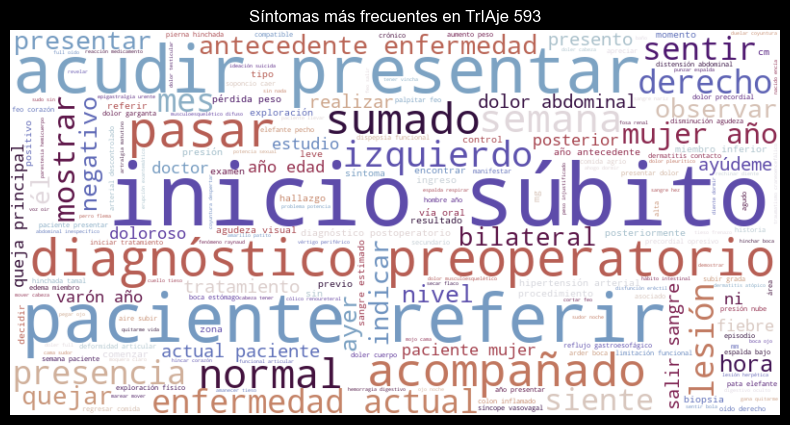

In [8]:
# Unir todo el texto procesado en un solo bloque gigante
texto_completo = " ".join(df_final['sintomas_procesados'])

# Generar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='twilight').generate(texto_completo)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Síntomas más frecuentes en TrIAje 593')

# Guardar la imagen de la nube de palabras
wordcloud.to_file('../data/external/nube_palabras_sintomas.png', dpi=600, transparent=True)

plt.show()